In [42]:
import pandas as pd

# Load datasets
cola_results = pd.read_csv('Results/cola_results.csv')
mnli_results = pd.read_csv('Results/mnli_results.csv')
mrpc_results = pd.read_csv('Results/mrpc_results.csv')
sst2_results = pd.read_csv('Results/sst2_results.csv')

# Preview data
print(cola_results.head())
print(mnli_results.head())
print(mrpc_results.head())
print(sst2_results.head())

                                            sentence  actual_label  \
0          To the washroom kissed the Blarney stone.             0   
1  Mary claimed that intelligent, I consider Holl...             0   
2                  The boys were made a good mother.             0   
3  Clearly, John immediately will probably learn ...             0   
4       Stephen is believed to be easy to annoy Ben.             0   

  predicted_label  
0    unacceptable  
1    unacceptable  
2    unacceptable  
3    unacceptable  
4    unacceptable  
                                             premise  \
0  The Council document also noted that inexplica...   
1  Notwithstanding any other paragraph of this su...   
2  Many evaluation questions do not require a hig...   
3  The sofa you see there now is a replica, the o...   
4  The lush river valley cuts deep into the heart...   

                                          hypothesis  actual_label  \
0  18-B lawyers are handling cases that appear to...

### First we will find all instances where the model answered incorrectly among the expected responses

In [43]:
# Define the expected responses for each task
expected_responses_cola = ['acceptable', 'unacceptable']
expected_responses_sst2 = ['positive', 'negative']
expected_responses_mrpc = ['paraphrase', 'not paraphrase']
expected_responses_mnli = ['entailment', 'neutral', 'contradiction']

# Define mapping from string to numerical labels
label_mapping_cola = {'acceptable': 1, 'unacceptable': 0}
label_mapping_sst2 = {'positive': 1, 'negative': 0}
label_mapping_mrpc = {'paraphrase': 1, 'not paraphrase': 0}
label_mapping_mnli = {'entailment': 0, 'neutral': 1, 'contradiction': 2}

# Function to invert labels for SST-2 if incorrect
def invert_sst2_label(label, actual_label):
    if label in expected_responses_sst2:
        return label_mapping_sst2[label]
    else:
        return 1 - actual_label  # Opposite label (0 -> 1, 1 -> 0)
    

# Convert predicted labels to numerical and handle incorrect responses
cola_results['predicted_label'] = cola_results['predicted_label'].apply(lambda x: label_mapping_cola[x] if x in expected_responses_cola else -1)

# Identify incorrect predictions and invert them
sst2_results['predicted_label'] = sst2_results.apply(lambda row: label_mapping_sst2[row['predicted_label']] if row['predicted_label'] in expected_responses_sst2 else 1 - row['actual_label'], axis=1)

mrpc_results['predicted_label'] = mrpc_results['predicted_label'].apply(lambda x: label_mapping_mrpc[x] if x in expected_responses_mrpc else -1)

mnli_results['predicted_label'] = mnli_results['predicted_label'].apply(lambda x: label_mapping_mnli[x] if x in expected_responses_mnli else -1)

# Ensure there are no missing or mislabelled data points
len(cola_results[cola_results['predicted_label'] != -1]), len(mrpc_results[mrpc_results['predicted_label'] != -1]), len(mnli_results[mnli_results['predicted_label'] != -1])

(900, 900, 900)

### For the most part the model responded according to what was asked, however for the sst2 task, there were 18 instances were the model responded with "neutral" instead of "positive" or "negative"

For these instances we decided to interpret them as incorrect answers, by changing the predicted label to be the opposite of the actual label.  
- considerations could be to ask the model again, or perform multiple requests and do majority voting (could also be a thing to talk about in discussion on how to get better results, also link to research that says multiple prompting and majority voting makes models better)

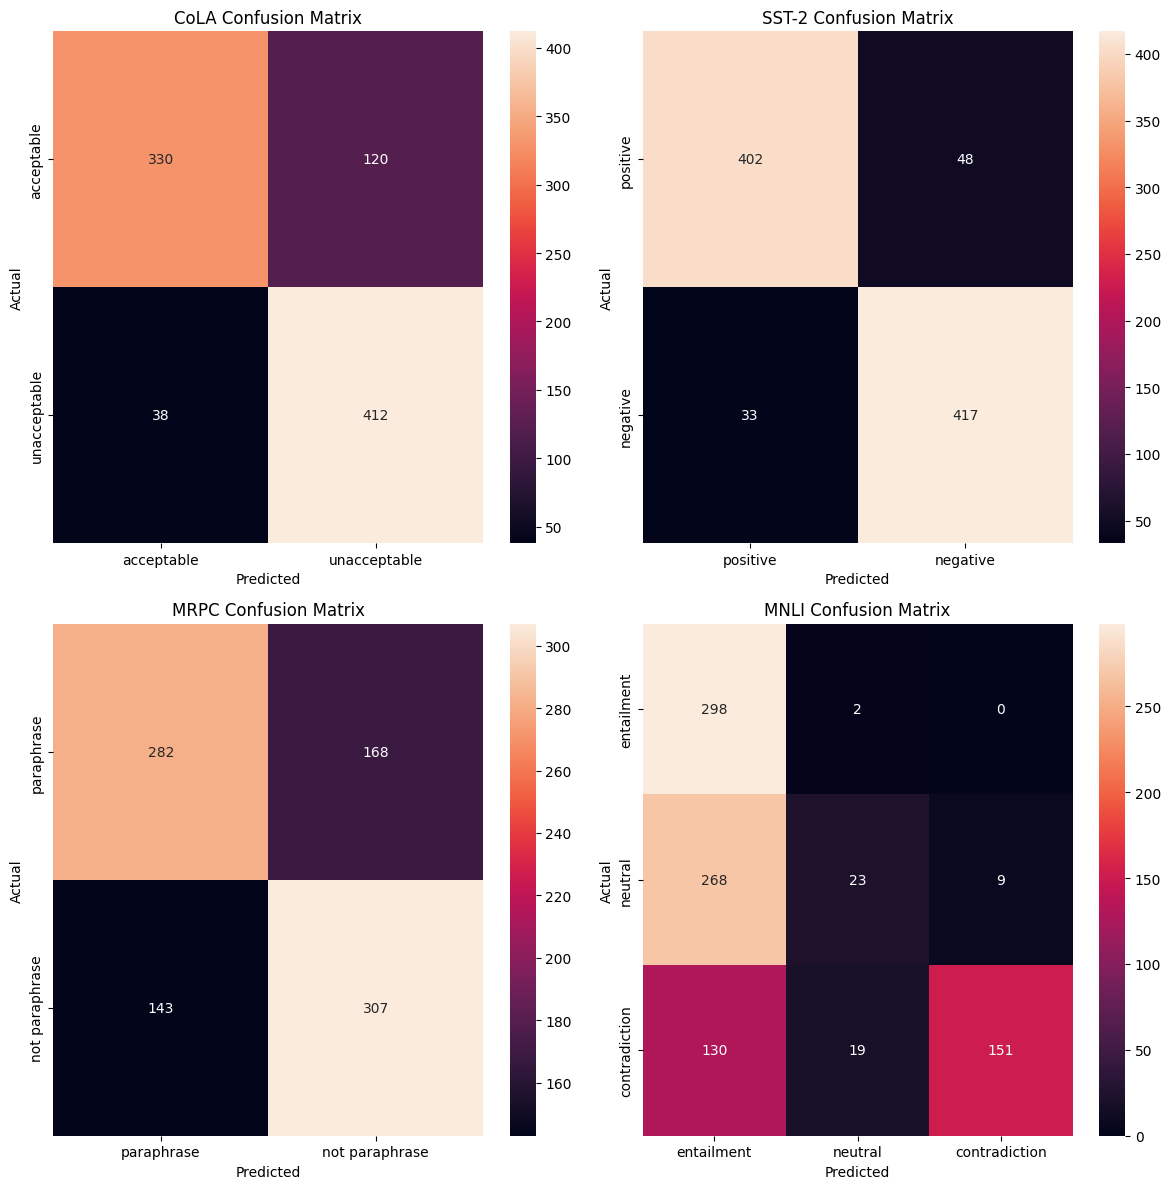

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert numerical labels back to string labels for confusion matrices
inverse_label_mapping_cola = {v: k for k, v in label_mapping_cola.items()}
inverse_label_mapping_sst2 = {v: k for k, v in label_mapping_sst2.items()}
inverse_label_mapping_mrpc = {v: k for k, v in label_mapping_mrpc.items()}
inverse_label_mapping_mnli = {v: k for k, v in label_mapping_mnli.items()}

# Create confusion matrices
cola_conf_matrix = confusion_matrix(cola_results['actual_label'], cola_results['predicted_label'])
sst2_conf_matrix = confusion_matrix(sst2_results['actual_label'], sst2_results['predicted_label'])
mrpc_conf_matrix = confusion_matrix(mrpc_results['actual_label'], mrpc_results['predicted_label'])
mnli_conf_matrix = confusion_matrix(mnli_results['actual_label'], mnli_results['predicted_label'])

# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

sns.heatmap(cola_conf_matrix, annot=True, fmt='d', ax=axes[0, 0], 
            xticklabels=list(inverse_label_mapping_cola.values()), 
            yticklabels=list(inverse_label_mapping_cola.values()))
axes[0, 0].set_title('CoLA Confusion Matrix')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')

sns.heatmap(sst2_conf_matrix, annot=True, fmt='d', ax=axes[0, 1], 
            xticklabels=list(inverse_label_mapping_sst2.values()), 
            yticklabels=list(inverse_label_mapping_sst2.values()))
axes[0, 1].set_title('SST-2 Confusion Matrix')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

sns.heatmap(mrpc_conf_matrix, annot=True, fmt='d', ax=axes[1, 0], 
            xticklabels=list(inverse_label_mapping_mrpc.values()), 
            yticklabels=list(inverse_label_mapping_mrpc.values()))
axes[1, 0].set_title('MRPC Confusion Matrix')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

sns.heatmap(mnli_conf_matrix, annot=True, fmt='d', ax=axes[1, 1], 
            xticklabels=list(inverse_label_mapping_mnli.values()), 
            yticklabels=list(inverse_label_mapping_mnli.values()))
axes[1, 1].set_title('MNLI Confusion Matrix')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

### Now calculate metrics

In [45]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Calculate metrics for each task
def calculate_metrics(y_true, y_pred, labels):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=labels, average='weighted')
    return accuracy, precision, recall, f1

# CoLA metrics
cola_labels = [0, 1]  # 'unacceptable', 'acceptable'
cola_accuracy, cola_precision, cola_recall, cola_f1 = calculate_metrics(cola_results['actual_label'], cola_results['predicted_label'], cola_labels)

# SST-2 metrics
sst2_labels = [0, 1]  # 'negative', 'positive'
sst2_accuracy, sst2_precision, sst2_recall, sst2_f1 = calculate_metrics(sst2_results['actual_label'], sst2_results['predicted_label'], sst2_labels)

# MRPC metrics
mrpc_labels = [0, 1]  # 'not paraphrase', 'paraphrase'
mrpc_accuracy, mrpc_precision, mrpc_recall, mrpc_f1 = calculate_metrics(mrpc_results['actual_label'], mrpc_results['predicted_label'], mrpc_labels)

# MNLI metrics
mnli_labels = [0, 1, 2]  # 'entailment', 'neutral', 'contradiction'
mnli_accuracy, mnli_precision, mnli_recall, mnli_f1 = calculate_metrics(mnli_results['actual_label'], mnli_results['predicted_label'], mnli_labels)

print(f"CoLA - Accuracy: {cola_accuracy}, Precision: {cola_precision}, Recall: {cola_recall}, F1: {cola_f1}")
print(f"SST-2 - Accuracy: {sst2_accuracy}, Precision: {sst2_precision}, Recall: {sst2_recall}, F1: {sst2_f1}")
print(f"MRPC - Accuracy: {mrpc_accuracy}, Precision: {mrpc_precision}, Recall: {mrpc_recall}, F1: {mrpc_f1}")
print(f"MNLI - Accuracy: {mnli_accuracy}, Precision: {mnli_precision}, Recall: {mnli_recall}, F1: {mnli_f1}")

CoLA - Accuracy: 0.8244444444444444, Precision: 0.8355876103301733, Recall: 0.8244444444444444, F1: 0.8229749177119695
SST-2 - Accuracy: 0.91, Precision: 0.9104560622914348, Recall: 0.91, F1: 0.9099749930536261
MRPC - Accuracy: 0.6544444444444445, Precision: 0.6549226006191949, Recall: 0.6544444444444445, F1: 0.6541776061776061
MNLI - Accuracy: 0.5244444444444445, Precision: 0.6315460640891676, Recall: 0.5244444444444445, F1: 0.4628787478867273


In [48]:
def perform_chi2_test(task_name, results_df):
    actual_label_col = 'actual_label'
    predicted_label_col = 'predicted_label'
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(results_df[actual_label_col], results_df[predicted_label_col])
    
    # Perform Chi-square test
    chi2, p_value, _, _ = chi2_contingency(conf_matrix)
    print(f"{task_name} Chi-square test: Chi2 = {chi2}, p-value = {p_value}")

# CoLA Chi-square test
perform_chi2_test("CoLA", cola_results)

# SST-2 Chi-square test
perform_chi2_test("SST-2", sst2_results)

# MRPC Chi-square test
perform_chi2_test("MRPC", mrpc_results)

# MNLI Chi-square test
perform_chi2_test("MNLI", mnli_results)

CoLA Chi-square test: Chi2 = 389.2862250735534, p-value = 1.1837698813411274e-86
SST-2 Chi-square test: Chi2 = 602.5539488320355, p-value = 4.659043761112619e-133
MRPC Chi-square test: Chi2 = 84.90204334365325, p-value = 3.135189684046053e-20
MNLI Chi-square test: Chi2 = 355.1989420062696, p-value = 1.3225433697151918e-75
